# HACKtheMACHINE 2021 | Track 2: Data Science, Detective Bot 

The following data dictionary describes the columns or fields of the data set and a description of the objects. This information with more detail can also be found in the `EMBER` documentation of the `features.py` file at: https://github.com/elastic/ember/blob/master/ember/features.py 

| Field Name | Description | 
|------------|-------------|
| sha256 | The Secure Hash Algorithm (SHA) is a cryptographic hash function like a signature or fingerprints for a data set. Even if one symbol is changed the algorithm will produce a different hash value. The SHA256 algorithm generates a fixed size 256-bit (32-byte) hash. The SHA256 algorithm is used to ensure you acquire the same data as the original. For exmaple, if you download something you can check if the data has not changed (due to network errors or malware injection) by comparing the hashes of your file and the original.|
| histogram | Byte histogram (count + non-normalized) over the entire binary file. The byte histogram contains 256 integer values and represent the counts of each byte value within the value. When generating model features the byte histgoram is normalized to a distribution, since file size is represented as a feature in the general file information. | 
| byteentropy | 2D byte/entropy histogram based loosely on (Saxe and Berlin, 2015). This roughly approximates the joint probability of byte value and local entropy. See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info. The byte entropy histogram approximates the joint distriubtion p(H, X) of entropy H and byte value X. By computing the scalar entropy H for a fixed-length window and pairing it with each byte occurrence within the window. This is repeated as the window slides across the input bytes. |
| strings | Contains simple statistics about printable strings of the following: <ul><li>`numstrings`: number of strings <li> `avlength`: average length of strings <li>`printabledist`: histogram of the printable characters within those strings <li>`printables`: distinct information from byte histogram information from the byte histogram information since its derived only from strings containing at least 5 consecutive printable characters <li>`entropy`: entropy of characters across all printable strings <li>`paths` number of strings that begin with **C:** (case insensitive) that may indicate a path <li>`urls`: the number of occurences of **http://** or **https://** (case insensitive) that may indicate a URL <li>`registry`: number of occurrences of HKEY that may indicate a registry key, <li>`MZ`: number of occurrences of the short string MZ |
| general | Provides general file information. 0/1 indicates a binary output <ul><li>`size`: length of bytes <li>`vsize`: virtual size <li>`has_debug`: 0/1  <li>`exports`: 0/1 <li>`imports`: 0/1 <li>`has_relocations`: 0/1  <li>`has_resources`: 0/1 <li>`has_signature`: 0/1 <li>`has_tls`: 0/1 <li>`symbols`: 0/1 |
| header | Provides header file information on machine, architecture, OS, link and other information: <ul><li> `coeff`: [ `timestamp`, `machine`,`characteristics` ] <li> `optional`: [`subsystem`, `dll_characteristics`, `magic`, `major_image_version`, `minor_linker_version`, `major_operating_system_version`, `minor_operating_system_version`, `major_subsystem_version`, `minor_subsystem_version`, `sizeof_code`, `sizeof_headers`, `sizeof_heap_commit`]
| section | Information about section names, sizes and entropy. Uses hashing trick to summarize all this section into a feature vector. <ul><li> `imports`: [`KERNEL32.dll` : [`GetTickCount`] | 
| imports | Information about imported libraries and functions from the import address table. Note that the total number of imported functions is contained in GeneralFileInfo. |
| exports | Information about exported functions. Note that the total number of exported functions is contained in GeneralFileInfo.|
| datadirectories | Extracts size and virtual address of the first 15 data dictectories. |
| label / category | Class label indicating benign `0` or malicious `1`|

## Load Libraries

In [7]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import sklearn as sk #modeling & metrics
import seaborn as sns #visualizations
import scipy as stats #visualizations
from matplotlib import pyplot as plt #visualizations

#imputation, scaling, metrics
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import r2_score, classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

#outlier classification
from sklearn.ensemble import IsolationForest

import xgboost as xgb #xgb model
import lightgbm as lgb #lgbm model
from lightgbm import *
import re #fix error for lgbm
import hyperopt #hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap #shap plot

import pickle 
 
import warnings
warnings.filterwarnings('ignore')

## Requirements

The requirements file is basically this output copy pasted into a txt file

In [8]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.2
pandas==1.3.4
sklearn==1.0.1
seaborn==0.11.2
scipy==1.6.0
xgboost==1.5.0
lightgbm==3.2.1
re==2.2.1
hyperopt==0.2.5
shap==0.40.0


## Load Data

In [9]:
# Flattened EMBER Feature set
# Easier to feed into ML models right away
# df1 = pd.read_excel("flatten_train.xlsx")

Use pickling so you don't have to re read Excel file every time.

In [10]:
# pd.to_pickle(df1, "./data.pkl")

In [11]:
df1 = pd.read_pickle("./data.pkl")

Checking how many malware entries.

In [12]:
sum(df1['category'])

900

In [13]:
df1.shape

(18000, 714)

In [14]:
900/18000

0.05

5%, super imbalanced.

## EDA

### Visualizations go here:
### try plotting distributions of certain features to compare them between the malware and not malware tables

In [15]:
df1.head(5)

,sha256,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,...,datadirectories_13_name,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_name,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_name,datadirectories_15_size,datadirectories_15_virtual_address,category
0,15f88c44e29e74965cbec984cd4244786eeb4ccde02328...,127242,9185,3818,3127,13300,1594,1781,1493,9938,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
1,29bb2a854de0f99bdb7120870ad42af6a3b5b5c6fc3578...,36152,2617,4120,876,1711,755,672,521,2278,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
2,5cd8667d8375bf799fe89ac9b74cf08bf69dfa18a4e551...,39986,7112,7953,6604,6542,6441,5869,6422,6224,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
3,ce63706c0adf4851a8d2eb26fa97750cfaec7345151367...,253873,32714,22629,17500,15355,6691,10881,4258,11992,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
4,5e65dd9986fc47c5fe45208fab5e1c78730699800eaf96...,12464,1020,502,264,1918,218,262,91,846,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0


In [16]:
list(df1)

['sha256',
 'histogram_0',
 'histogram_1',
 'histogram_2',
 'histogram_3',
 'histogram_4',
 'histogram_5',
 'histogram_6',
 'histogram_7',
 'histogram_8',
 'histogram_9',
 'histogram_10',
 'histogram_11',
 'histogram_12',
 'histogram_13',
 'histogram_14',
 'histogram_15',
 'histogram_16',
 'histogram_17',
 'histogram_18',
 'histogram_19',
 'histogram_20',
 'histogram_21',
 'histogram_22',
 'histogram_23',
 'histogram_24',
 'histogram_25',
 'histogram_26',
 'histogram_27',
 'histogram_28',
 'histogram_29',
 'histogram_30',
 'histogram_31',
 'histogram_32',
 'histogram_33',
 'histogram_34',
 'histogram_35',
 'histogram_36',
 'histogram_37',
 'histogram_38',
 'histogram_39',
 'histogram_40',
 'histogram_41',
 'histogram_42',
 'histogram_43',
 'histogram_44',
 'histogram_45',
 'histogram_46',
 'histogram_47',
 'histogram_48',
 'histogram_49',
 'histogram_50',
 'histogram_51',
 'histogram_52',
 'histogram_53',
 'histogram_54',
 'histogram_55',
 'histogram_56',
 'histogram_57',
 'histogram_5

In [17]:
malware = df1[df1['category'] == 1]
not_malware = df1[df1['category'] == 0]

In [18]:
def dist_plotter(feature_name): #random function, make some more
    fig, ax = plt.subplots(2,1)
#     ax.set(ylabel='common ylabel', title=feature_name)
    sns.violinplot(malware[feature_name], inner="quartile", ax=ax[0], color='r')
    sns.violinplot(not_malware[feature_name], inner="quartile", ax=ax[1], color='r')

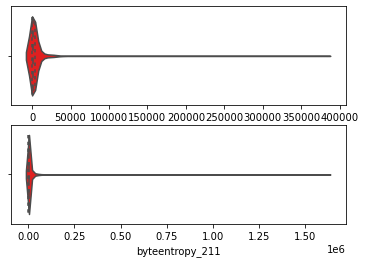

In [19]:
dist_plotter('byteentropy_211')

## Undersampling

Since only 5% of entries are malware, we want a similar 50/50 split between malware and not malware.

In [20]:
majority = df1[df1.category==0] # Majority class
minority = df1[df1.category==1] # Minority class

In [21]:
majority_undersampled = resample(majority, replace=False, n_samples=900) # Randomly selects 900 records from majority to match minority class size
# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 900 from majority
df_undersampled.category.value_counts()

0    900
1    900
Name: category, dtype: int64

In [22]:
df = df_undersampled #make it a new df

In [23]:
X = df.drop('category', axis=1) #X is everything but the 'category' col

In [24]:
y = df['category'] #y is just the target column

In [25]:
X = X._get_numeric_data() #drop all nonnumeric ones (for now?)

In [26]:
print(X.shape, y.shape) #sanity check arrays

(1800, 693) (1800,)


## Feature Selection with ANOVA

Ideally should have selected features after heatmaps/correlation plots/distributions etc but skipped all that for now.

This is automatic but more of a "black box".

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #train test split 80/20

In [28]:
fs = SelectKBest(score_func=f_classif, k=600) #THIS K IS HOW MANY FEATURES YOU WANT
fs.fit(X_train, y_train)
mask = fs.get_support()
new_features = X_train.columns[mask]

In [29]:
X_train_fs = X_train[new_features]
X_test_fs = X_test[new_features]

In [30]:
# for i in range(len(fs.scores_[:10])):
#     print('Feature %d: %f' % (i, fs.scores_[i]))
# # plot the scores
#     plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#     plt.show()

Now we can use X_train_fs and X_test_fs in place of X_train and X_test.

In [31]:
print(X_train_fs.shape, X_test_fs.shape)

(1440, 600) (360, 600)


In [32]:
print(y_train.shape, y_test.shape)

(1440,) (360,)


## Modeling

This function basically fits a specified model and outputs it's f1_score as well as ROC curve, can add more graphs/plots to it as well.

In [33]:
def modeler(model):
    model.fit(X_train_fs, y_train) #fit specified model
    y_pred = model.predict(X_test_fs) #predict on test set
    f1 = f1_score(y_test, y_pred) #get f1 score
    print('F1 Score:', f1)
    print(metrics.confusion_matrix(y_test, y_pred))
    
    #this plots the ROC curve, play around iwth it
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

F1 Score: 0.7213930348258707
[[103  77]
 [ 35 145]]


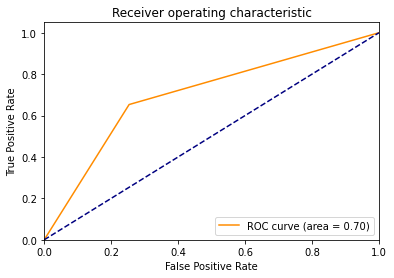

In [34]:
lr = LogisticRegression()
modeler(lr)

F1 Score: 0.8933717579250722
[[168  12]
 [ 25 155]]


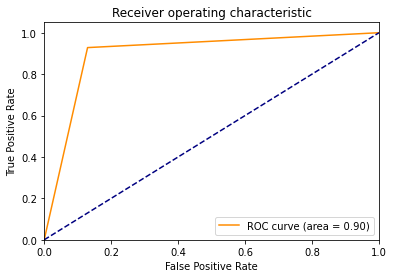

In [35]:
lgbm = lgb.LGBMClassifier()
modeler(lgbm)

[08:16:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score: 0.8806818181818182
[[163  17]
 [ 25 155]]


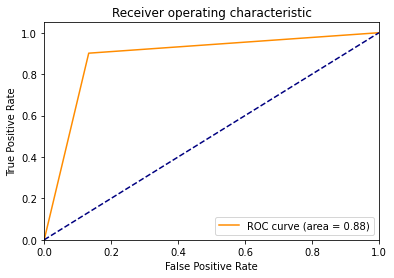

In [36]:
xgbc = xgb.XGBClassifier()
modeler(xgbc)

F1 Score: 0.8197674418604651
[[157  23]
 [ 39 141]]


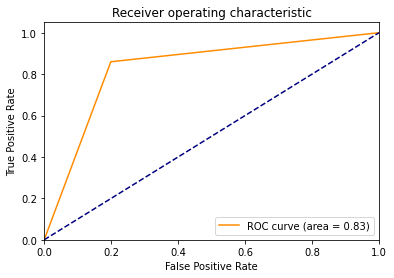

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
modeler(rf)

F1 Score: 0.6004962779156329
[[ 78 102]
 [ 59 121]]


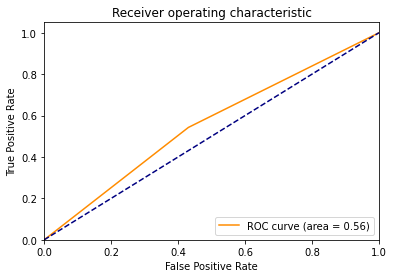

In [38]:
from sklearn.svm import SVC
svm = SVC()
modeler(svm)

F1 Score: 0.6929577464788733
[[128  52]
 [ 57 123]]


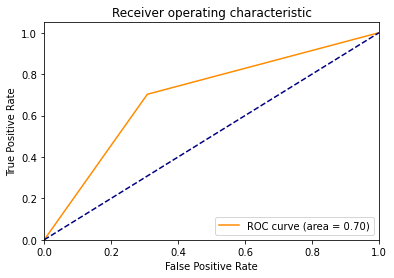

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
modeler(knn)

F1 Score: 0.7855153203342619
[[142  38]
 [ 39 141]]


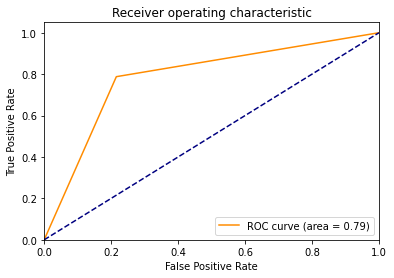

In [40]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
modeler(dt)

Best ones seem to be LGBM and XGB. Ideal ROC graph looks hugs the top left corner.

## Hyperparameter Optimization

Time to tune with Hyperopt.
(Scaling/normalizing isn't needed for gradient boosted decision trees so skip it)

# EVERYONE CAN TRY OPTIMIZING WITH DIFFERENT HYPERPARAMETERS LIKE IN THE COMMENTED OUT LINES, check the user docs for more parameters

In [41]:
#hyperparameter domain to search over
hyperparam_space = {
    'num_leaves':       hp.choice('num_leaves', np.arange(30, 250, 1)),
    'learning_rate':    hp.quniform('learning_rate', 0, 0.3, 0.01),
    'max_depth':        hp.choice('max_depth', np.arange(2, 100, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
    'subsample':        hp.uniform('subsample', 0.5, 1),
}

Following code takes a couple minutes to run:

In [42]:
def score(params): #function to train and test different hyperparams
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
#     y_pred = model.predict(X_test_fs)
#     score = mean_squared_error(y_test, y_pred)
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return score
            
def optimize(trials, space): #fmin is the main library function
    best = fmin(score, space, algo=tpe.suggest, max_evals=10)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_params = optimize(trials, hyperparam_space) #calls fmin

#finds best hyperparameters
# space_eval(hyperparam_space, best_params)

[1]	training's binary_logloss: 0.633095	valid_1's binary_logloss: 0.646721                            
Training until validation scores don't improve for 20 rounds                                          
[2]	training's binary_logloss: 0.581464	valid_1's binary_logloss: 0.610199                            
[3]	training's binary_logloss: 0.537015	valid_1's binary_logloss: 0.580914                            
[4]	training's binary_logloss: 0.498375	valid_1's binary_logloss: 0.54998                             
[5]	training's binary_logloss: 0.46356	valid_1's binary_logloss: 0.524428                             
[6]	training's binary_logloss: 0.433429	valid_1's binary_logloss: 0.505295                            
[7]	training's binary_logloss: 0.405941	valid_1's binary_logloss: 0.486604                            
[8]	training's binary_logloss: 0.381391	valid_1's binary_logloss: 0.470727                            
[9]	training's binary_logloss: 0.359762	valid_1's binary_logloss: 0.45731

[79]	training's binary_logloss: 0.0638677	valid_1's binary_logloss: 0.281716                          
[80]	training's binary_logloss: 0.0633435	valid_1's binary_logloss: 0.28145                           
[81]	training's binary_logloss: 0.0626265	valid_1's binary_logloss: 0.281871                          
[82]	training's binary_logloss: 0.0621481	valid_1's binary_logloss: 0.28135                           
[83]	training's binary_logloss: 0.0616736	valid_1's binary_logloss: 0.281276                          
[84]	training's binary_logloss: 0.0610537	valid_1's binary_logloss: 0.281324                          
[85]	training's binary_logloss: 0.0604329	valid_1's binary_logloss: 0.281619                          
[86]	training's binary_logloss: 0.0599035	valid_1's binary_logloss: 0.281354                          
[87]	training's binary_logloss: 0.0592711	valid_1's binary_logloss: 0.282412                          
[88]	training's binary_logloss: 0.0586886	valid_1's binary_logloss: 0.282

[54]	training's binary_logloss: 0.358608	valid_1's binary_logloss: 0.412097                           
[55]	training's binary_logloss: 0.356764	valid_1's binary_logloss: 0.411061                           
[56]	training's binary_logloss: 0.354412	valid_1's binary_logloss: 0.409676                           
[57]	training's binary_logloss: 0.352294	valid_1's binary_logloss: 0.407771                           
[58]	training's binary_logloss: 0.350414	valid_1's binary_logloss: 0.40678                            
[59]	training's binary_logloss: 0.348295	valid_1's binary_logloss: 0.405579                           
[60]	training's binary_logloss: 0.346147	valid_1's binary_logloss: 0.404811                           
[61]	training's binary_logloss: 0.344867	valid_1's binary_logloss: 0.403671                           
[62]	training's binary_logloss: 0.343139	valid_1's binary_logloss: 0.401566                           
[63]	training's binary_logloss: 0.341858	valid_1's binary_logloss: 0.4008

[29]	training's binary_logloss: 0.327053	valid_1's binary_logloss: 0.386111                           
[30]	training's binary_logloss: 0.324527	valid_1's binary_logloss: 0.384139                           
[31]	training's binary_logloss: 0.320189	valid_1's binary_logloss: 0.382164                           
[32]	training's binary_logloss: 0.316829	valid_1's binary_logloss: 0.380773                           
[33]	training's binary_logloss: 0.314419	valid_1's binary_logloss: 0.377882                           
[34]	training's binary_logloss: 0.311545	valid_1's binary_logloss: 0.376046                           
[35]	training's binary_logloss: 0.309273	valid_1's binary_logloss: 0.374889                           
[36]	training's binary_logloss: 0.307805	valid_1's binary_logloss: 0.373268                           
[37]	training's binary_logloss: 0.305457	valid_1's binary_logloss: 0.370155                           
[38]	training's binary_logloss: 0.303414	valid_1's binary_logloss: 0.3677

[4]	training's binary_logloss: 0.410973	valid_1's binary_logloss: 0.471995                            
[5]	training's binary_logloss: 0.384951	valid_1's binary_logloss: 0.448875                            
[6]	training's binary_logloss: 0.367913	valid_1's binary_logloss: 0.434757                            
[7]	training's binary_logloss: 0.35167	valid_1's binary_logloss: 0.417203                             
[8]	training's binary_logloss: 0.338865	valid_1's binary_logloss: 0.410244                            
[9]	training's binary_logloss: 0.321446	valid_1's binary_logloss: 0.39834                             
[10]	training's binary_logloss: 0.312415	valid_1's binary_logloss: 0.390582                           
[11]	training's binary_logloss: 0.302684	valid_1's binary_logloss: 0.378394                           
[12]	training's binary_logloss: 0.293087	valid_1's binary_logloss: 0.373066                           
[13]	training's binary_logloss: 0.286891	valid_1's binary_logloss: 0.3708

[26]	training's binary_logloss: 0.253955	valid_1's binary_logloss: 0.341238                           
[27]	training's binary_logloss: 0.251607	valid_1's binary_logloss: 0.341619                           
[28]	training's binary_logloss: 0.248989	valid_1's binary_logloss: 0.338439                           
[29]	training's binary_logloss: 0.245613	valid_1's binary_logloss: 0.337819                           
[30]	training's binary_logloss: 0.242889	valid_1's binary_logloss: 0.336767                           
[31]	training's binary_logloss: 0.241603	valid_1's binary_logloss: 0.335224                           
[32]	training's binary_logloss: 0.239472	valid_1's binary_logloss: 0.336386                           
[33]	training's binary_logloss: 0.237177	valid_1's binary_logloss: 0.332384                           
[34]	training's binary_logloss: 0.235905	valid_1's binary_logloss: 0.332125                           
[35]	training's binary_logloss: 0.233983	valid_1's binary_logloss: 0.3323

Training until validation scores don't improve for 20 rounds                                          
[2]	training's binary_logloss: 0.575784	valid_1's binary_logloss: 0.594874                            
[3]	training's binary_logloss: 0.534531	valid_1's binary_logloss: 0.559591                            
[4]	training's binary_logloss: 0.500946	valid_1's binary_logloss: 0.529919                            
[5]	training's binary_logloss: 0.474304	valid_1's binary_logloss: 0.510831                            
[6]	training's binary_logloss: 0.45264	valid_1's binary_logloss: 0.490844                             
[7]	training's binary_logloss: 0.429566	valid_1's binary_logloss: 0.467939                            
[8]	training's binary_logloss: 0.415545	valid_1's binary_logloss: 0.457688                            
[9]	training's binary_logloss: 0.396912	valid_1's binary_logloss: 0.443133                            
[10]	training's binary_logloss: 0.384594	valid_1's binary_logloss: 0.4304

[80]	training's binary_logloss: 0.220936	valid_1's binary_logloss: 0.33016                            
[81]	training's binary_logloss: 0.220162	valid_1's binary_logloss: 0.330539                           
[82]	training's binary_logloss: 0.21965	valid_1's binary_logloss: 0.329738                            
[83]	training's binary_logloss: 0.218791	valid_1's binary_logloss: 0.329541                           
[84]	training's binary_logloss: 0.218175	valid_1's binary_logloss: 0.329261                           
[85]	training's binary_logloss: 0.217427	valid_1's binary_logloss: 0.328913                           
[86]	training's binary_logloss: 0.216844	valid_1's binary_logloss: 0.329103                           
[87]	training's binary_logloss: 0.216127	valid_1's binary_logloss: 0.329297                           
[88]	training's binary_logloss: 0.215578	valid_1's binary_logloss: 0.329164                           
[89]	training's binary_logloss: 0.21478	valid_1's binary_logloss: 0.32783

[55]	training's binary_logloss: 0.24587	valid_1's binary_logloss: 0.341399                            
[56]	training's binary_logloss: 0.244034	valid_1's binary_logloss: 0.340866                           
[57]	training's binary_logloss: 0.242993	valid_1's binary_logloss: 0.340407                           
[58]	training's binary_logloss: 0.242055	valid_1's binary_logloss: 0.338897                           
[59]	training's binary_logloss: 0.240727	valid_1's binary_logloss: 0.338596                           
[60]	training's binary_logloss: 0.239277	valid_1's binary_logloss: 0.336787                           
[61]	training's binary_logloss: 0.237958	valid_1's binary_logloss: 0.336313                           
[62]	training's binary_logloss: 0.236969	valid_1's binary_logloss: 0.335493                           
[63]	training's binary_logloss: 0.235488	valid_1's binary_logloss: 0.335214                           
[64]	training's binary_logloss: 0.234414	valid_1's binary_logloss: 0.3352

[30]	training's binary_logloss: 0.182874	valid_1's binary_logloss: 0.327381                           
[31]	training's binary_logloss: 0.179627	valid_1's binary_logloss: 0.32639                            
[32]	training's binary_logloss: 0.178111	valid_1's binary_logloss: 0.327089                           
[33]	training's binary_logloss: 0.176783	valid_1's binary_logloss: 0.326752                           
[34]	training's binary_logloss: 0.174563	valid_1's binary_logloss: 0.326801                           
[35]	training's binary_logloss: 0.172759	valid_1's binary_logloss: 0.326436                           
[36]	training's binary_logloss: 0.170962	valid_1's binary_logloss: 0.32291                            
[37]	training's binary_logloss: 0.169804	valid_1's binary_logloss: 0.321576                           
[38]	training's binary_logloss: 0.168376	valid_1's binary_logloss: 0.318638                           
[39]	training's binary_logloss: 0.166193	valid_1's binary_logloss: 0.3200

[47]	training's binary_logloss: 0.011771	valid_1's binary_logloss: 0.299948                           
[48]	training's binary_logloss: 0.011372	valid_1's binary_logloss: 0.299186                           
[49]	training's binary_logloss: 0.0110024	valid_1's binary_logloss: 0.298401                          
[50]	training's binary_logloss: 0.0106021	valid_1's binary_logloss: 0.298652                          
[51]	training's binary_logloss: 0.0102871	valid_1's binary_logloss: 0.299686                          
[52]	training's binary_logloss: 0.0100053	valid_1's binary_logloss: 0.300642                          
Early stopping, best iteration is:                                                                    
[32]	training's binary_logloss: 0.0241179	valid_1's binary_logloss: 0.290909
-0.9701774691358025                                                                                   
[1]	training's binary_logloss: 0.660747	valid_1's binary_logloss: 0.665867                         

[70]	training's binary_logloss: 0.182418	valid_1's binary_logloss: 0.310633                           
[71]	training's binary_logloss: 0.18125	valid_1's binary_logloss: 0.309912                            
[72]	training's binary_logloss: 0.180098	valid_1's binary_logloss: 0.308695                           
[73]	training's binary_logloss: 0.178781	valid_1's binary_logloss: 0.308921                           
[74]	training's binary_logloss: 0.177739	valid_1's binary_logloss: 0.307805                           
[75]	training's binary_logloss: 0.17678	valid_1's binary_logloss: 0.308078                            
[76]	training's binary_logloss: 0.175234	valid_1's binary_logloss: 0.307837                           
[77]	training's binary_logloss: 0.174132	valid_1's binary_logloss: 0.307062                           
[78]	training's binary_logloss: 0.172903	valid_1's binary_logloss: 0.306213                           
[79]	training's binary_logloss: 0.171447	valid_1's binary_logloss: 0.3061

In [43]:
best_params

{'colsample_bytree': 0.7450599014986924,
 'learning_rate': 0.1,
 'max_depth': 38,
 'min_child_weight': 6,
 'num_leaves': 209,
 'subsample': 0.5429510461462432}

In [44]:
lgbm_model = lgb.LGBMClassifier(**best_params)
lgbm_model.fit(X_train_fs, y_train)
preds = [pred[1] for pred in lgbm_model.predict_proba(X_test_fs)]
score = roc_auc_score(y_test, preds, average='weighted')
print('auc_roc score on test data: ', score)

auc_roc score on test data:  0.9544135802469136


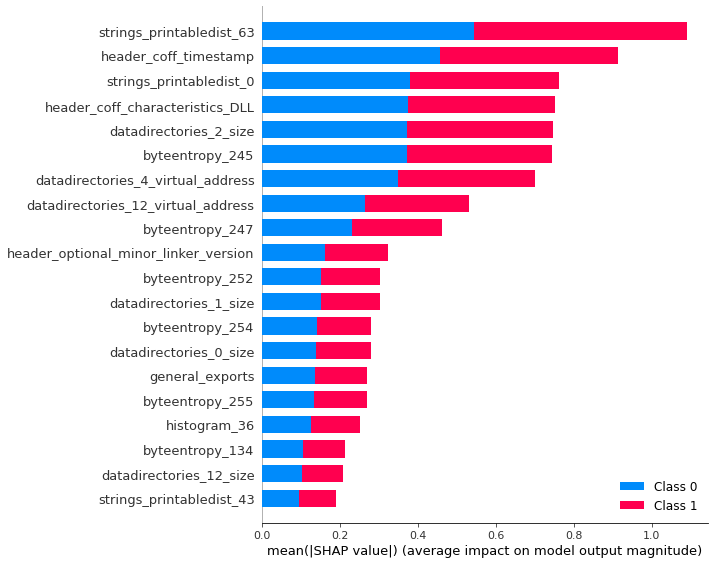

In [45]:
shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_test_fs)
shap.summary_plot(shap_values, X_test_fs)

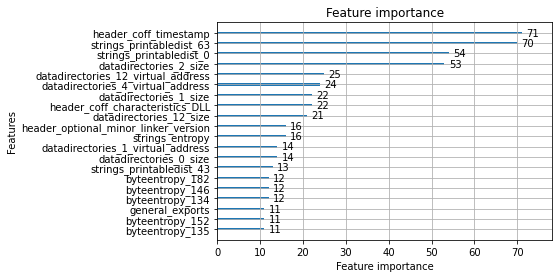

<Figure size 1800x864 with 0 Axes>

In [46]:
lgb.plot_importance(lgbm_model, max_num_features=20)
plt.figure(figsize=(25, 12))
plt.show()

In [50]:
y_pred = lgbm_model.predict(X_test_fs)
f1 = f1_score(y_test, y_pred) #get f1 score
print('F1 Score:', f1)
print(metrics.confusion_matrix(y_test, y_pred))

F1 Score: 0.8850574712643678
[[166  14]
 [ 26 154]]


In [51]:
#hyperparameter domain to search over
hyperparam_space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 10, 1, dtype=int)), #larger values = overfitting
    'n_estimators': hp.choice('n_estimators', np.arange(1, 100, 1, dtype=int)), #larger values = overfitting
    'learning_rate': hp.quniform('learning_rate', 0, 1, 0.01), #aka eta = step size shrinkage to prevent overfitting
    'gamma': hp.quniform('gamma', 0, 1, 0.1), #gamma: min loss reduction to partition leaf nodes (for overfitting)
#     lambda: L2 regularization (Ridge)
#     alpha: L1 regularization (Lasso)
}

In [ ]:
def xgb_score(params): #function to train and test different hyperparams
    model = xgb.XGBClassifier(**params, eval_metric='logloss')
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return {'loss': score, 'status': STATUS_OK}
            
def xgb_optimize(trials, space): #fmin is the main library function
    best = fmin(xgb_score, space, algo=tpe.suggest, max_evals=10)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_xgb_params = xgb_optimize(trials, hyperparam_space) #calls fmin

[0]	validation_0-logloss:0.54956	validation_1-logloss:0.60654                                         
[1]	validation_0-logloss:0.45100	validation_1-logloss:0.55593                                         
[2]	validation_0-logloss:0.37422	validation_1-logloss:0.51550                                         
[3]	validation_0-logloss:0.31462	validation_1-logloss:0.47958                                         
[4]	validation_0-logloss:0.26849	validation_1-logloss:0.45708                                         
[5]	validation_0-logloss:0.22879	validation_1-logloss:0.43915                                         
[6]	validation_0-logloss:0.19830	validation_1-logloss:0.42364                                         
[7]	validation_0-logloss:0.17214	validation_1-logloss:0.41184                                         
[8]	validation_0-logloss:0.14996	validation_1-logloss:0.39944                                         
[9]	validation_0-logloss:0.13109	validation_1-logloss:0.39410            

[41]	validation_0-logloss:0.02056	validation_1-logloss:0.30086                                        
[42]	validation_0-logloss:0.02056	validation_1-logloss:0.30088                                        
[43]	validation_0-logloss:0.02056	validation_1-logloss:0.30090                                        
[44]	validation_0-logloss:0.02056	validation_1-logloss:0.30091                                        
-0.9669753086419753                                                                                   
[0]	validation_0-logloss:0.25933	validation_1-logloss:0.50282                                         
[1]	validation_0-logloss:0.14209	validation_1-logloss:0.47027                                         
[2]	validation_0-logloss:0.08537	validation_1-logloss:0.44143                                         
[3]	validation_0-logloss:0.05601	validation_1-logloss:0.43608                                         
[4]	validation_0-logloss:0.04035	validation_1-logloss:0.44178            

[28]	validation_0-logloss:0.02787	validation_1-logloss:0.32206                                        
[29]	validation_0-logloss:0.02639	validation_1-logloss:0.32828                                        
[30]	validation_0-logloss:0.02500	validation_1-logloss:0.32920                                        
[31]	validation_0-logloss:0.02312	validation_1-logloss:0.32664                                        
[32]	validation_0-logloss:0.02220	validation_1-logloss:0.33056                                        
[33]	validation_0-logloss:0.02127	validation_1-logloss:0.33238                                        
[34]	validation_0-logloss:0.02030	validation_1-logloss:0.33041                                        
[35]	validation_0-logloss:0.01939	validation_1-logloss:0.33008                                        
[36]	validation_0-logloss:0.01862	validation_1-logloss:0.32883                                        
[37]	validation_0-logloss:0.01782	validation_1-logloss:0.32988           

In [ ]:
best_xgb_params

In [ ]:
xgb_model = xgb.XGBClassifier(**best_xgb_params, eval_metric='logloss')
xgb_model.fit(X_train_fs, y_train)
preds = [pred[1] for pred in xgb_model.predict_proba(X_test_fs)]
score = roc_auc_score(y_test, preds, average='weighted')
print('auc_roc score on test data: ', score)

In [ ]:
y_pred = xgb_model.predict(X_test_fs)
f1=f1_score(y_test, y_pred) #get f1 score
print('F1 Score:', f1)
print(metrics.confusion_matrix(y_test, y_pred))

In [ ]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test_fs)
shap.summary_plot(shap_values, X_test_fs)

In [ ]:
xgb.plot_importance(xgb_model, importance_type='cover', max_num_features=20)
plt.figure(figsize=(25, 12))
plt.show()

## Conclusions

## Visualizations should include the above ROC plots, SHAP plots, as well as the built in feature importance plots.

# scrap the below in final version

### Anomaly Detection Approach??

In [42]:
df1.shape #go back to original dataset

(18000, 714)

In [43]:
df1 = df1._get_numeric_data() #drop nonnumeric columns

#### Isolation Forest

Setting contamination rate to 5% as seen in original data, using 200 estimators.

In [44]:
iso = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.05)
new_df = df1.drop(columns=['category'])
iso.fit(new_df)
new_df['anomaly_score'] = iso.predict(new_df)
new_df[new_df['anomaly_score'] == -1].shape

(900, 694)

As expected, found 900 "outliers" (in our case malware).

In [45]:
iso_df = pd.concat([new_df, df1['category']], axis=1) #join the anomaly prediction with og data
iso_df.head(10)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_size,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,620,11711244,0,0,0,0,0,0,1,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,340,131072,0,0,0,0,0,0,1,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,588,123728,0,0,0,0,0,0,1,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,216,282920,0,0,0,0,0,0,1,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,0,1,0
5,17889,1281,868,642,914,138,311,148,433,82,...,0,0,0,0,0,0,0,0,1,0
6,224255,28215,12691,13046,21264,4115,3790,3590,11766,1889,...,408,1188328,0,0,0,0,0,0,1,0
7,14195,1054,778,1068,291,653,251,249,338,164,...,0,0,0,0,0,0,0,0,1,0
8,48208,3288,1441,2611,4938,313,266,635,2104,231,...,1284,230880,0,0,0,0,0,0,1,0
9,370224,37570,24575,18127,40687,15614,12405,11777,24099,5331,...,0,0,0,0,0,0,0,0,1,0


In [46]:
iso_df.groupby('anomaly_score').size() #sanity check

anomaly_score
-1      900
 1    17100
dtype: int64

In [47]:
iso_df['anomaly'] = "" #add new empty column to switch out -1 to 1 and 1 to 0

In [48]:
iso_df.loc[iso_df.anomaly_score == -1, "anomaly"] = 1
iso_df.loc[iso_df.anomaly_score == 1, "anomaly"] = 0

In [49]:
print(iso_df.groupby('anomaly').size(), iso_df.groupby('category').size())

anomaly
0    17100
1      900
dtype: int64 category
0    17100
1      900
dtype: int64


In [50]:
iso_df.head(5)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category,anomaly
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,11711244,0,0,0,0,0,0,1,0,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,131072,0,0,0,0,0,0,1,0,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,123728,0,0,0,0,0,0,1,0,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,282920,0,0,0,0,0,0,1,0,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,1,0,0


Calculate f1 score between new anomaly column and given category column.

In [51]:
f1_score(list(iso_df['category']), list(iso_df['anomaly']))

0.008888888888888889

### what happened???